## Plotting the data using Parallel Coordinate Displays

Enter the dataset file name with .csv extension
Cars.csv


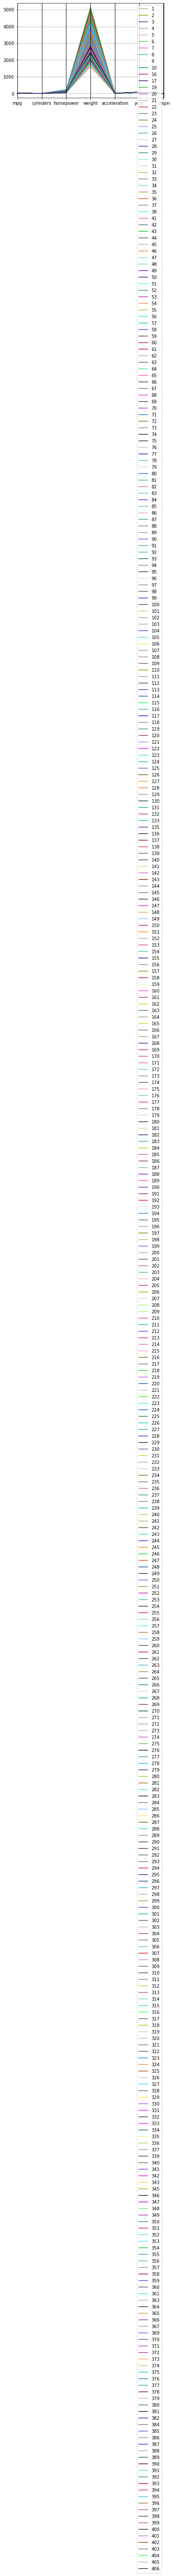

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

# Load the dataset into a pandas dataframe
print("Enter the dataset file name with .csv extension")
df_o = pd.read_csv(input())

# Drop rows with missing values
df_o = df_o.dropna()

# Plot the data using parallel coordinate displays
parallel_coordinates(df_o, class_column=list(df_o.columns)[0])
plt.show()


## Reduction of data dimensionality to 10 components

In [2]:
from sklearn.decomposition import PCA

if df_o.shape[1] > 15:
    # Apply PCA for dimensionality reduction
    pca = PCA(n_components=10)
    df = pca.fit_transform(df_o)
else:
    df=df_o

df.to_csv('my_data_reduced.csv', index=False)


In [3]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, gaussian_kde
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

In [4]:
df = pd.read_csv("my_data_reduced.csv")
df.dropna(inplace=True)

In [5]:
df

,Name,mpg,cylinders,horsepower,weight,acceleration,year,origin
0,1,18.0,8,130.0,3504,12.0,70,1
1,2,15.0,8,165.0,3693,11.5,70,1
2,3,18.0,8,150.0,3436,11.0,70,1
3,4,16.0,8,150.0,3433,12.0,70,1
4,5,17.0,8,140.0,3449,10.5,70,1
...,...,...,...,...,...,...,...,...
387,402,27.0,4,86.0,2790,15.6,82,1
388,403,44.0,4,52.0,2130,24.6,82,2
389,404,32.0,4,84.0,2295,11.6,82,1
390,405,28.0,4,79.0,2625,18.6,82,1


In [6]:
cols=list(df.columns)[1:]

In [7]:
def init_val():
    val={}
    for i in cols:
        val[i]={}
        for j in cols:
            if i!=j:
                val[i][j]=0
    return val

## Correlation

In [8]:
def find_corr(col1,col2):
    corr, _ = pearsonr(df[col1], df[col2])
    return corr

## Covariance

In [9]:
cov_matrix=df.cov()

In [10]:
cov_matrix

,Name,mpg,cylinders,horsepower,weight,acceleration,year,origin
Name,13244.819119,526.584383,-70.967339,-1880.986690,-31512.425348,93.033694,422.538285,18.621457
mpg,526.584383,60.918142,-10.352928,-233.857926,-5517.440704,9.115514,16.691477,3.553510
cylinders,-70.967339,-10.352928,2.909696,55.348244,1300.424363,-2.375052,-2.171930,-0.781734
horsepower,-1880.986690,-233.857926,55.348244,1481.569393,28265.620231,-73.186967,-59.036432,-14.112741
weight,-31512.425348,-5517.440704,1300.424363,28265.620231,721484.709008,-976.815253,-967.228457,-400.266050
acceleration,93.033694,9.115514,-2.375052,-73.186967,-976.815253,7.611331,2.950462,0.472788
year,422.538285,16.691477,-2.171930,-59.036432,-967.228457,2.950462,13.569915,0.538650
origin,18.621457,3.553510,-0.781734,-14.112741,-400.266050,0.472788,0.538650,0.648860


## Density Change

In [11]:
def cal_den(a,b):
    # Get the PDF values of each column
    pdf_a = gaussian_kde(df[a])(df[a])
    pdf_b = gaussian_kde(df[b])(df[b])

    # Add a small constant to avoid divide-by-zero errors
    eps = 1e-9
    pdf_a += eps
    pdf_b += eps

    # Normalize the PDFs to make sure they sum to 1
    pdf_a /= pdf_a.sum()
    pdf_b /= pdf_b.sum()

    # Calculate the KL divergence
    kl_div = np.sum(pdf_a * np.log(pdf_a / pdf_b))
    return kl_div

In [12]:
cal_den(cols[0],cols[2])

0.2141266925762649

## Outliers

In [13]:
def outliers(column, threshold=2):
    z_scores = np.abs((df[column] - df[column].mean()) / df[column].std())
    return np.where(z_scores > threshold)[0]
    

In [14]:
len(outliers(cols[4]))

21

## Neighbourhood

In [15]:
def parallelism(x, y):
    col_x=df[x]
    col_y=df[y]
    angles = np.arctan2(col_y - col_x, 1)
    variance = np.var(angles)
    return 1 - variance / (np.pi / 2)

In [16]:
parallelism(cols[2],cols[4])

0.9999759145496475

## Fan

In [17]:
def divergence(x, y, nbins=10):
    col_x=df[x]
    col_y=df[y]
    hist, xedges, yedges = np.histogram2d(col_x, col_y, bins=nbins)
    main_axis_counts = np.sum(hist, axis=1)
    secondary_axis_counts = np.sum(hist > 0, axis=0)
    divergence = np.sum(main_axis_counts * secondary_axis_counts) / np.sum(hist)
    return 1 - divergence / nbins

In [18]:
divergence(cols[2],cols[4])

0.34846938775510206

## Clear Grouping

In [19]:
def clr_grp(x,y):
    W = 100

    # Select the two columns to compare
    col1 = df[x]
    col2 = df[y]

    # Initialize array to hold clear grouping scores
    scores = np.zeros(len(col1))

    # Iterate over each point in the first column
    for i in range(len(col1)):
        # Find the W nearest neighbors along the same column
        neighbors1 = col1.iloc[max(i - W, 0) : min(i + W + 1, len(col1))]
        neighbors2 = col2.iloc[max(i - W, 0) : min(i + W + 1, len(col2))]

        # Calculate probability distribution for each neighbor using Equation 6
        p1 = np.exp(-(neighbors1 - col1.iloc[i])**2 / np.std(neighbors1)**2)
        p2 = np.exp(-(neighbors2 - col2.iloc[i])**2 / np.std(neighbors2)**2)
        p1 /= np.sum(p1)
        p2 /= np.sum(p2)

        # Calculate KL divergence using Equation 7
        kl_div = np.sum(p1 * np.log(p1 / p2))

        # Add to total score
        scores[i] = kl_div

    # Calculate final clear grouping score using Equation 8
    cg_score = np.sum(scores) / (len(col1) * (len(col1) - 1))

    # Normalize using precomputed mean and standard deviation
    mean_cg = 0.1 # Replace with actual mean from sample
    std_cg = 0.05 # Replace with actual standard deviation from sample
    norm_cg = (cg_score - mean_cg) / std_cg

    return cg_score


## Calculating for each axes and Normalizing the values

In [20]:
def normalize_list(values):
    mean_val = sum(values) / len(values)
    std_val = (sum((x - mean_val) ** 2 for x in values) / len(values)) ** 0.5
    normalized_values = [(x - mean_val) / std_val for x in values]
    return normalized_values


In [21]:
corr_list=[]
covar_list=[]
skew_list=[]
den_chn_list=[]
outlie_list=[]
neigh_list=[]
fan_list=[]
cl_gp_list=[]
spl_list=[]
for i in cols:
    for j in cols:
        if i!=j:
            corr_list.append(find_corr(i,j))
            covar_list.append(cov_matrix.loc[i,j])
            skew_list.append(df[j].skew())
            den_chn_list.append(cal_den(i,j))
            outlie_list.append(len(outliers(j)))
            neigh_list.append(parallelism(i,j))
            fan_list.append(divergence(i,j))
            cl_gp_list.append(clr_grp(i,j))
            spl_list.append(1-clr_grp(i,j))
# print(corr_list,'\n',covar_list,'\n',skew_list,'\n',den_chn_list,'\n',outlie_list,'\n',neigh_list,'\n',fan_list,'\n',cl_gp_list)

In [22]:
corr_list=normalize_list(corr_list)
covar_list=normalize_list(covar_list)
skew_list=normalize_list(skew_list)
den_chn_list=normalize_list(den_chn_list)
outlie_list=normalize_list(outlie_list)
neigh_list=normalize_list(neigh_list)
fan_list=normalize_list(fan_list)
cl_gp_list=normalize_list(cl_gp_list)
spl_list=normalize_list(spl_list)

# print(corr_list,'\n',covar_list,'\n',skew_list,'\n',den_chn_list,'\n',outlie_list,'\n',neigh_list,'\n',fan_list,'\n',cl_gp_list)

## Taking weights(including negative) for the metrics from the user and calcualting pie chart

In [23]:
import random
def random_color_code():
    red = random.randint(0, 255)
    green = random.randint(0, 255)
    blue = random.randint(0, 255)
    return "#{:02x}{:02x}{:02x}".format(red, green, blue)

Please Enter '0' if u dont want to consider any property 

Enter the percentage weight of Positive Correlation to be considered:  9
Enter the percentage weight of Negative Correlation to be considered:  47
Enter the percentage weight of Positive Covariance to be considered:  56
Enter the percentage weight of Negative Covariance to be considered:  -30
Enter the percentage weight of Positive Skew to be considered:  24
Enter the percentage weight of Negative Skew to be considered:  15
Enter the percentage weight of Outliers to be considered:  0
Enter the percentage weight of Clear Grouping to be considered:  13
Enter the percentage weight of Split Up to be considered:  0
Enter the percentage weight of Fan to be considered:  22
Enter the percentage weight of Neighbourhood to be considered:  92
Enter the percentage weight of Density Change to be considered:  10


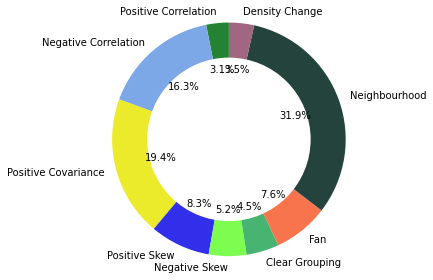

In [24]:
val=init_val()

print("Please Enter '0' if u dont want to consider any property \n")
per_weights={}
print("Enter the percentage weight of Positive Correlation to be considered: ",end=" ")
per_weights['Positive Correlation']=int(input())
print("Enter the percentage weight of Negative Correlation to be considered: ",end=" ")
per_weights['Negative Correlation']=int(input())
print("Enter the percentage weight of Positive Covariance to be considered: ",end=" ")
per_weights['Positive Covariance']=int(input())
print("Enter the percentage weight of Negative Covariance to be considered: ",end=" ")
per_weights['Negative Covariance']=int(input())
print("Enter the percentage weight of Positive Skew to be considered: ",end=" ")
per_weights['Positive Skew']=int(input())
print("Enter the percentage weight of Negative Skew to be considered: ",end=" ")
per_weights['Negative Skew']=int(input())
print("Enter the percentage weight of Outliers to be considered: ",end=" ")
per_weights['Outliers']=int(input())
print("Enter the percentage weight of Clear Grouping to be considered: ",end=" ")
per_weights['Clear Grouping']=int(input())
print("Enter the percentage weight of Split Up to be considered: ",end=" ")
per_weights['Split Up']=int(input())
print("Enter the percentage weight of Fan to be considered: ",end=" ")
per_weights['Fan']=int(input())
print("Enter the percentage weight of Neighbourhood to be considered: ",end=" ")
per_weights['Neighbourhood']=int(input())
print("Enter the percentage weight of Density Change to be considered: ",end=" ")
per_weights['Density Change']=int(input())





y=list(per_weights.values())
sizes = []
labels = []
for i in y:
    if i>0:
        sizes.append(i)
for i in sizes:
    for key, value in per_weights.items():
        if i == value:
            labels.append(key)

colors = []
for i in range(len(labels)):
    colors.append(random_color_code())
# Create pie chart
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)

# Add circle to create donut chart
circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(circle)

# Display chart
plt.axis('equal')
plt.tight_layout()
plt.show()





In [25]:
# print(y,labels,sizes)

## Calculating the final value for each axis pair

In [26]:
x=0
for i in cols:
    for j in cols:
        if i!=j:
            if corr_list[x]>0:
                val[i][j]+=(per_weights['Positive Correlation']/100)*corr_list[x]
            else:
                val[i][j]+=(per_weights['Negative Correlation']/100)*corr_list[x]
            if covar_list[x]>0:
                val[i][j]+=(per_weights['Positive Covariance']/100)*covar_list[x]
            else:
                val[i][j]+=(per_weights['Negative Covariance']/100)*covar_list[x]
            if skew_list[x]>0:
                val[i][j]+=(per_weights['Positive Skew']/100)*skew_list[x]
            else:
                val[i][j]+=(per_weights['Negative Skew']/100)*skew_list[x]
            
            val[i][j]+=(per_weights['Outliers']/100)*outlie_list[x]    
            val[i][j]+=(per_weights['Clear Grouping']/100)*cl_gp_list[x]
            val[i][j]+=(per_weights['Split Up']/100)*den_chn_list[x]
            val[i][j]+=(per_weights['Fan']/100)*fan_list[x]
            val[i][j]+=(per_weights['Neighbourhood']/100)*neigh_list[x]
            val[i][j]+=(per_weights['Density Change']/100)*den_chn_list[x]
            
            
            x+=1
            


In [27]:
for i in val:
    val[i] = dict(sorted(val[i].items(), key=lambda x: x[1]))
print(val)

{'mpg': {'acceleration': -1.2285430242686, 'weight': -0.40754042261442414, 'cylinders': -0.22432281770034634, 'year': -0.14632600221485273, 'horsepower': -0.03243339728518369, 'origin': 0.9754650974477467}, 'cylinders': {'mpg': -0.23784404061395079, 'year': -0.12636626003632012, 'acceleration': 0.06555530057674322, 'weight': 0.26467654299238663, 'origin': 0.6228740399727262, 'horsepower': 0.7811871916372948}, 'horsepower': {'year': -4.748360929945693, 'mpg': -0.5436126347583768, 'acceleration': -0.5040000217700946, 'cylinders': 0.4634343289485343, 'origin': 0.9043743003773914, 'weight': 2.5292759881466735}, 'weight': {'year': -0.48722210375616964, 'mpg': -0.35893941624933284, 'acceleration': -0.18049613299142814, 'cylinders': 0.3372786623646956, 'origin': 0.6809425671751643, 'horsepower': 2.883447206325462}, 'acceleration': {'mpg': -1.2082690301426238, 'weight': -0.1675004387347711, 'year': -0.12968350052907207, 'horsepower': 0.0821612622472965, 'cylinders': 0.18838185282822528, 'origi

## Calculating Heat Map

In [28]:

# print(rows)
heat_df= pd.DataFrame(index=list(val.keys()), columns=list(val.keys()))
for i in val:
    for j in val[i]:
        heat_df.loc[i,j]=val[i][j]
        heat_df.loc[i,i]=float(0)
heat_df

,mpg,cylinders,horsepower,weight,acceleration,year,origin
mpg,0.0,-0.224323,-0.032433,-0.40754,-1.228543,-0.146326,0.975465
cylinders,-0.237844,0.0,0.781187,0.264677,0.065555,-0.126366,0.622874
horsepower,-0.543613,0.463434,0.0,2.529276,-0.504,-4.748361,0.904374
weight,-0.358939,0.337279,2.883447,0.0,-0.180496,-0.487222,0.680943
acceleration,-1.208269,0.188382,0.082161,-0.1675,0.0,-0.129684,1.219531
year,0.147116,0.196912,-3.835611,-0.10756,0.150927,0.0,0.811471
origin,0.581504,0.25331,0.957066,0.240388,0.850517,0.253668,0.0


In [29]:
for i in heat_df.columns:
    heat_df[i] = heat_df[i].astype('float')

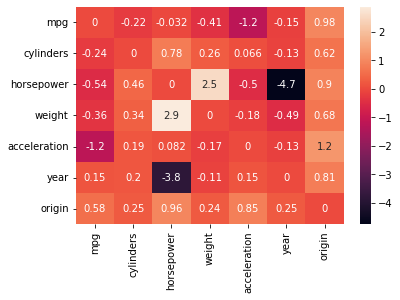

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# create the heatmap using seaborn
sns.heatmap(heat_df,annot=True)

# display the plot
plt.show()


## Reordering the axes based on the values

In [31]:
# Sort the dictionary by values and get the key with the highest value
max_key = max(val, key=lambda k: max(val[k].values()))
# Get the key of the max_key with the highest value
sub_max_key = max(val[max_key], key=val[max_key].get)
new_o=[list(df.columns)[0],max_key,sub_max_key]

for i in range(len(cols)-2):
    y=-1
    x=list(val[sub_max_key].keys())[y]
    while x in new_o:
        y=y-1
        x=list(val[sub_max_key].keys())[y]
    new_o.append(x)
    sub_max_key=x
# print("Key with highest value: ", max_key)
# print("Key of that key: ", sub_max_key)
# print(val[max_key])
print(new_o)

['Name', 'weight', 'horsepower', 'origin', 'acceleration', 'cylinders', 'year', 'mpg']


In [32]:
df = df.reindex(columns=new_o)

## PCP plot after reordering axes

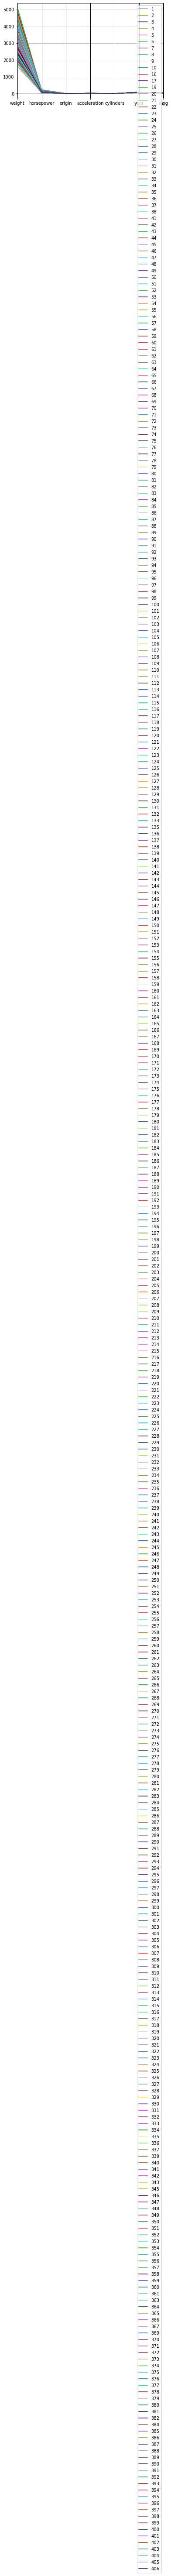

In [33]:
parallel_coordinates(df, class_column=list(df.columns)[0])
plt.show()